In [1]:
import pandas as pd
import numpy as np
import ImagingReso as reso
from scipy.interpolate import interp1d
import periodictable as pt
from ImagingReso.resonance import Resonance
import ImagingReso._utilities as ir_util
import matplotlib.pyplot as plt

In [2]:
def convert_to_df_at(df_wt: pd.DataFrame):
    df_at = pd.DataFrame()
    for ele in df_wt.columns.values:
        if ele not in ['height_mm', 'density']:
            df_at[ele] = df_wt[ele]/pt.elements.isotope(ele).mass * 10000
    return df_at

def convert_to_chem_formula(df_at: pd.DataFrame):
    form_df = pd.DataFrame()
    form_list = []
    for e_row in range(len(df_at)):
        _str = ''
        for e_ele in df_at.columns.values:
            _num = str(int(round(df_at[e_ele][e_row])))
            _str =_str + e_ele + _num
        form_list.append(_str)
    form_df["formula"] = form_list
    return form_df

def extrapolate_thickness(thickness_ct, height_array):
    interp_type = 'cubic'
    interp_function = interp1d(x=thickness_ct["Height (mm)"], y=thickness_ct["Thickness (mm)"], kind=interp_type)
    thickness_interp = interp_function(height_array)
    return abs(thickness_interp)

def _load_beam_shape(relative_path_to_beam_shape):
    # Load beam shape from static
    df = pd.read_csv(relative_path_to_beam_shape, sep='\t', skiprows=0)
    df.columns = ['wavelength_A', 'flux']
    # Get rid of crazy data
    df.drop(df[df.wavelength_A < 0].index, inplace=True)
    df.drop(df[df.flux <= 0].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    # Convert wavelength to energy
    energy_array = ir_util.angstroms_to_ev(df['wavelength_A'])
    df.insert(1, 'energy_eV', round(energy_array, 6))
    # df.insert(1, 'energy_eV', energy_array)
    return df

def _calculate_transmission(flux_df: pd.DataFrame, trans_array: np.array):
    # calculated transmitted flux
    trans_flux = trans_array * flux_df['flux']
    integr_total = np.trapz(y=flux_df['flux'] / flux_df['energy_eV'], x=flux_df['energy_eV'], dx=1e-6).round(3)
    integr_trans = np.trapz(y=trans_flux / flux_df['energy_eV'], x=flux_df['energy_eV'], dx=1e-6).round(3)
    _trans = integr_trans / integr_total * 100
    return _trans

def _transmission_to_mu_per_cm(transmission, thickness):
    mu_per_cm = -np.log(transmission / 100) / (thickness / 10)
    return mu_per_cm

def calculate_tranmission(chem, thickness, density, relative_path_to_beam_shape):
    df_flux_raw = _load_beam_shape(relative_path_to_beam_shape)
    e_min = df_flux_raw['energy_eV'].min()
    e_max = df_flux_raw['energy_eV'].max()
    e_step = (e_max - e_min) / (100 - 1)
    o_reso = Resonance(energy_min=e_min, energy_max=e_max, energy_step=e_step, database='ENDF_VII')
    o_reso.add_layer(formula=chem, thickness=thickness, density=density)
    o_stack = o_reso.stack
    
    energy = o_reso.total_signal['energy_eV'].round(6)  # !!!need to fix ImagingReso energy_eV columns    
    interp_type = 'cubic'
    interp_flux_function = interp1d(x=df_flux_raw['energy_eV'], y=df_flux_raw['flux'], kind=interp_type)
    flux_interp = interp_flux_function(energy)
    df_flux_interp = pd.DataFrame()
    df_flux_interp['energy_eV'] = energy
    df_flux_interp['flux'] = flux_interp
    df_flux = df_flux_interp[:]
    trans_tag = 'transmission'
    mu_tag = 'mu_per_cm'
    peak_tag = (u" (2.53 \u212B)")

    o_signal = o_reso.stack_signal
    
    wave = ir_util.ev_to_angstroms(energy).round(2)
    peak_neutron_idx = np.where(wave == 2.53)[0][0]
    _peak = wave[peak_neutron_idx]
    _total_trans_at_peak = round(o_reso.total_signal[trans_tag][peak_neutron_idx] * 100, 6)
    _total_trans = _calculate_transmission(flux_df=df_flux, trans_array=o_reso.total_signal[trans_tag])

    for each_layer in o_stack.keys():
        _current_layer_thickness = o_stack[each_layer]['thickness']['value']
        if len(o_stack.keys()) == 1:
            _current_layer_trans = _total_trans
            _current_layer_trans_at_peak = _total_trans_at_peak
        else:
            _current_layer_trans = _calculate_transmission(flux_df=df_flux,
                                                           trans_array=o_signal[each_layer][trans_tag])
            _current_layer_trans_at_peak = o_signal[each_layer][trans_tag][peak_neutron_idx]

        o_stack[each_layer][trans_tag] = _current_layer_trans
        o_stack[each_layer][mu_tag] = _transmission_to_mu_per_cm(transmission=_current_layer_trans,
                                                                 thickness=_current_layer_thickness)
        
        o_stack[each_layer][trans_tag + peak_tag] = _current_layer_trans_at_peak
        o_stack[each_layer][mu_tag + peak_tag] = _transmission_to_mu_per_cm(transmission=_current_layer_trans_at_peak,
                                                                 thickness=_current_layer_thickness)
        for each_ele in o_stack[each_layer]['elements']:
            _current_ele_trans = _calculate_transmission(flux_df=df_flux,
                                                         trans_array=o_signal[each_layer][each_ele][trans_tag])
            o_stack[each_layer][each_ele][trans_tag] = _current_ele_trans
            o_stack[each_layer][each_ele][mu_tag] = _transmission_to_mu_per_cm(transmission=_current_ele_trans,
                                                                               thickness=_current_layer_thickness)
            _current_ele_trans_at_peak = round(o_signal[each_layer][each_ele][trans_tag][peak_neutron_idx] * 100, 6)
            o_stack[each_layer][each_ele][trans_tag + peak_tag] = _current_ele_trans_at_peak
            o_stack[each_layer][each_ele][mu_tag + peak_tag] = _transmission_to_mu_per_cm(transmission=_current_ele_trans_at_peak,
                                                                               thickness=_current_layer_thickness)
    return _total_trans_at_peak, _total_trans, o_stack

In [3]:
comp_wt_df = pd.read_csv("GE_sample_EPMA_wt.csv")
comp_wt_df

,Ni,Co,Cr,Al,Mo,Ti,Nb,Fe,height_mm,density
0,51.300,0.427,18.592,0.513,2.888,2.004,4.856,18.372,0.0000,8.2006
1,51.016,0.431,18.539,0.514,2.897,1.109,5.523,18.230,0.0650,8.2006
2,51.591,0.247,18.705,0.531,2.916,1.048,5.594,17.830,0.1299,8.2006
3,51.759,0.225,19.467,0.518,2.820,1.029,5.012,17.995,0.1949,8.2006
4,51.812,0.231,18.615,0.528,2.921,0.972,5.031,18.014,0.2599,8.2006
...,...,...,...,...,...,...,...,...,...,...
310,52.214,10.610,21.595,1.470,9.377,3.202,0.056,2.963,20.1410,8.2712
311,51.984,10.491,21.528,1.440,9.684,3.356,0.100,2.937,20.2059,8.2712
312,52.496,10.645,20.924,1.450,9.111,2.943,0.100,3.031,20.2709,8.2712
313,51.553,10.425,21.475,1.426,9.917,3.384,0.113,2.911,20.3359,8.2712


In [4]:
comp_at_df = convert_to_df_at(comp_wt_df)
comp_at_df

,Ni,Co,Cr,Al,Mo,Ti,Nb,Fe
0,8740.335370,72.454915,3575.652789,190.130007,301.021472,418.660037,522.676699,3289.820038
1,8691.948328,73.133650,3565.459717,190.500630,301.959558,231.683623,594.469400,3264.392515
2,8789.915050,41.911860,3597.385189,196.801235,303.939962,218.939980,602.111502,3192.765691
3,8818.538371,38.178819,3743.934641,191.983126,293.933709,214.970648,539.467795,3222.311756
4,8827.568347,39.196921,3580.076198,195.689364,304.461122,203.062653,541.512865,3225.714030
...,...,...,...,...,...,...,...,...
310,8896.059864,1800.343440,4153.196105,544.816978,977.381697,668.936846,6.027573,530.575701
311,8856.873175,1780.151086,4140.310523,533.698264,1009.380863,701.109324,10.763523,525.919957
312,8944.106152,1806.282367,4024.147965,537.404502,949.656035,614.828588,10.763523,542.752261
313,8783.440728,1768.951966,4130.117451,528.509531,1033.666875,706.958865,12.162782,521.264213


In [5]:
form_df = convert_to_chem_formula(comp_at_df)
thickness_ct = pd.read_csv("GE_thickness_from_CT_correct.csv")
form_df['thickness'] = extrapolate_thickness(thickness_ct, comp_wt_df['height_mm'])
form_df['density'] = comp_wt_df['density']

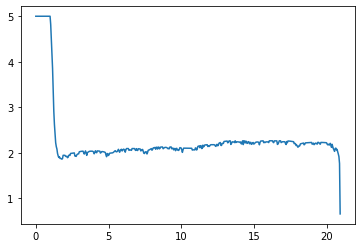

In [6]:
plt.plot(thickness_ct["Height (mm)"], thickness_ct["Thickness (mm)"])

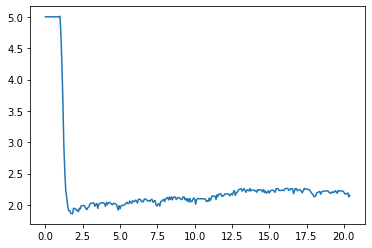

In [7]:
plt.plot(comp_wt_df["height_mm"], form_df["thickness"])

In [8]:
form_df

,formula,thickness,density
0,Ni8740Co72Cr3576Al190Mo301Ti419Nb523Fe3290,5.000640,8.2006
1,Ni8692Co73Cr3565Al191Mo302Ti232Nb594Fe3264,5.000640,8.2006
2,Ni8790Co42Cr3597Al197Mo304Ti219Nb602Fe3193,5.000640,8.2006
3,Ni8819Co38Cr3744Al192Mo294Ti215Nb539Fe3222,5.000640,8.2006
4,Ni8828Co39Cr3580Al196Mo304Ti203Nb542Fe3226,5.000640,8.2006
...,...,...,...
310,Ni8896Co1800Cr4153Al545Mo977Ti669Nb6Fe531,2.180676,8.2712
311,Ni8857Co1780Cr4140Al534Mo1009Ti701Nb11Fe526,2.177483,8.2712
312,Ni8944Co1806Cr4024Al537Mo950Ti615Nb11Fe543,2.193763,8.2712
313,Ni8783Co1769Cr4130Al529Mo1034Ti707Nb12Fe521,2.131031,8.2712


In [9]:
trans_list = []
mu_per_cm_list = []
trans_at_peak_list = []
mu_per_cm_at_peak_list = []
trans_tag = 'transmission'
mu_tag = 'mu_per_cm'
peak_tag = (u" (2.53 \u212B)")
for e_row in range(len(form_df)):
# for e_row in range(1):
    total_trans_at_peak, total_trans, o_stack = calculate_tranmission(form_df['formula'][e_row], form_df['thickness'][e_row], form_df['density'][e_row], "beam_flux_cg1d.txt")
    trans_list.append(total_trans)
    mu_per_cm_list.append(o_stack[form_df['formula'][e_row]][mu_tag])
    trans_at_peak_list.append(total_trans_at_peak)
    mu_per_cm_at_peak_list.append(o_stack[form_df['formula'][e_row]][mu_tag + peak_tag])
# print(peak_tag)
# print(mu_per_cm_list)
# print(mu_per_cm_at_peak_list)
# print(trans_list)
# print(trans_at_peak_list)
form_df['height'] = comp_wt_df['height_mm']
form_df[trans_tag] = trans_list
form_df[mu_tag] = mu_per_cm_list
form_df[trans_tag + peak_tag] = trans_at_peak_list
form_df[mu_tag + peak_tag] = mu_per_cm_at_peak_list

In [10]:
form_df

,formula,thickness,density,height,transmission,mu_per_cm,transmission (2.53 Å),mu_per_cm (2.53 Å)
0,Ni8740Co72Cr3576Al190Mo301Ti419Nb523Fe3290,5.000640,8.2006,0.0000,45.336799,1.581900,47.085119,1.506234
1,Ni8692Co73Cr3565Al191Mo302Ti232Nb594Fe3264,5.000640,8.2006,0.0650,45.494364,1.574962,47.229359,1.500117
2,Ni8790Co42Cr3597Al197Mo304Ti219Nb602Fe3193,5.000640,8.2006,0.1299,45.630173,1.569001,47.349532,1.495035
3,Ni8819Co38Cr3744Al192Mo294Ti215Nb539Fe3222,5.000640,8.2006,0.1949,45.591689,1.570689,47.313267,1.496567
4,Ni8828Co39Cr3580Al196Mo304Ti203Nb542Fe3226,5.000640,8.2006,0.2599,45.464379,1.576280,47.181151,1.502159
...,...,...,...,...,...,...,...,...
310,Ni8896Co1800Cr4153Al545Mo977Ti669Nb6Fe531,2.180676,8.2712,20.1410,64.849515,1.986085,66.910205,1.842634
311,Ni8857Co1780Cr4140Al534Mo1009Ti701Nb11Fe526,2.177483,8.2712,20.2059,65.015892,1.977230,67.069318,1.834428
312,Ni8944Co1806Cr4024Al537Mo950Ti615Nb11Fe543,2.193763,8.2712,20.2709,64.490806,1.999521,66.559735,1.855580
313,Ni8783Co1769Cr4130Al529Mo1034Ti707Nb12Fe521,2.131031,8.2712,20.3359,65.687984,1.972070,67.720136,1.829099


In [11]:
form_df.to_csv('GE_calculated_trans_5.csv')